In [82]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('seaborn')
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markeredgewidth'] = 1

import json
import re
from typing import Union

In [8]:
# Load results from JSON files
results_dir = "../results"

def libname_of_path(path):
    return re.search(".*lib(.*)\.so(.\d)?", path).group(1)


benchmarks = [
    'dlopen-dlclose',
    'dlsym',
    'function-call',
    'lazy-binding',
    # 'pngtest'
]

In [3]:
def load_benchmark_results(file_prefix: str, benchmark_type: Union[str, None] = None):
    
    if benchmark_type is None:
        benchmark_type = file_prefix

    with open(f"{results_dir}/{file_prefix}-baseline.json") as fp_baseline:
        res = dict()
        raw = json.load(fp_baseline)
        outer_iterations = raw[benchmark_type]['outer-iterations']
        inner_iterations = raw[benchmark_type]['inner-iterations']
        for lib in raw[benchmark_type]['libraries']:
            libname = libname_of_path(lib['library-path'])
            lib.pop('library-path')
            res[libname] = lib

        # We drop the first few iterations for each library because it will usually take longer due to paging in stuff etc.
        baseline = (pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname').iloc[10:]
                              for key in res.keys()]) / inner_iterations
                   )
                   # ).assign(**{
                   #      'branch-mispredicts/branches(%)': lambda df: 100. * df.loc[:, 'branch-mispredicts'] / df.loc[:, 'branches']
                   # }).drop(columns=['branch-mispredicts'])

    with open(f"{results_dir}/{file_prefix}-sandbox.json") as fp_sandbox:
        res = dict()
        raw = json.load(fp_sandbox)
        assert raw[f'{benchmark_type}-sandbox']['outer-iterations'] == outer_iterations
        assert raw[f'{benchmark_type}-sandbox']['inner-iterations'] == inner_iterations
        for lib in raw[f'{benchmark_type}-sandbox']['libraries']:
            libname = libname_of_path(lib['library-path'])
            lib.pop('library-path')
            res[libname] = lib

        sandbox = (pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname').iloc[10:]
                              for key in res.keys()]) / inner_iterations
                  )
                  # ).assign(**{
                  #      'branch-mispredicts/branches(%)': lambda df: 100. * df.loc[:, 'branch-mispredicts'] / df.loc[:, 'branches']
                  # }).drop(columns=['branch-mispredicts'])
        
    return baseline, sandbox


In [79]:
def plot_benchmark_data(baseline: pd.DataFrame, sandbox: pd.DataFrame):
    
    libnames = set(baseline.index.values).intersection(sandbox.index.values)
    print(f"Libraries: {libnames}")
    counters = set(baseline.columns).intersection(sandbox.columns)
    print(f"Counters: {counters}")

    fig, axss = plt.subplots(nrows=len(libnames), ncols=len(counters), figsize=(12, 6*len(libnames)))

    for rowindex, libname in enumerate(sorted(libnames)):
        axs = axss[rowindex] if len(libnames) > 1 else axss
        axs[0].set_title(libname)

        for counter, ax in zip(sorted(counters, reverse=True), axs.ravel()):
            ax.hist(
                [baseline.loc[libname, counter].values, sandbox.loc[libname, counter].values],
                bins=15, histtype='stepfilled',
                color=['blue', 'orange'], alpha=.4,
                label=[benchmark, f'{benchmark}-sandbox']
            )
            baseline_median = baseline.loc[libname, counter].median()
            sandbox_median = sandbox.loc[libname, counter].median()
            ax.axvline(x=sandbox_median, color='orange', label=f"median={sandbox_median:,.2f}")
            ax.axvline(x=baseline_median, color='blue', label=f"median={baseline_median:,.2f}")
            ax.set_xlabel(counter)
            handles, labels = ax.get_legend_handles_labels()
            handles.append(mpatches.Patch(color='white',
                                          label=f"$\\%$ overhead: ${100 * (sandbox_median / baseline_median - 1):.2f}\\%$\\\\"
                                                "(median/median - $100\\%$)"))
            ax.legend(handles=handles, loc='upper right')

    fig.tight_layout()

    plt.show()

In [5]:
benchmark = "pngtest-parameterised/pngtest-on-testpng32"
baseline, sandbox = load_benchmark_results(benchmark, "pngtest")

==== dlopen-dlclose ====
Libraries: {'hello_world'}
Counters: {'BR_MIS_PRED', 'INST_RETIRED', 'CPU_CYCLES'}


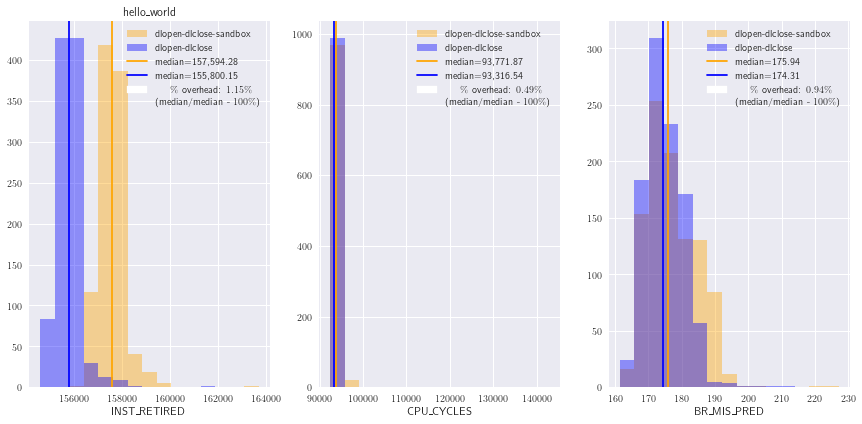

==== dlsym ====
Libraries: {'hello_world_1000'}
Counters: {'BR_MIS_PRED', 'INST_RETIRED', 'CPU_CYCLES'}


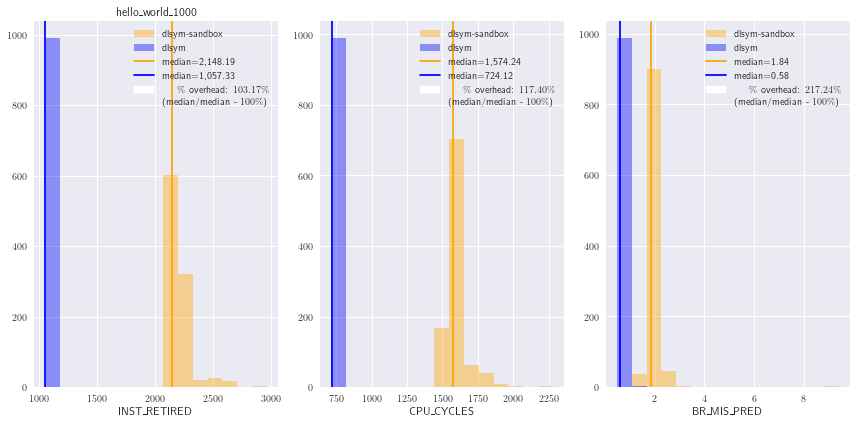

==== function-call ====
Libraries: {'hello_world'}
Counters: {'BR_MIS_PRED', 'INST_RETIRED', 'CPU_CYCLES'}


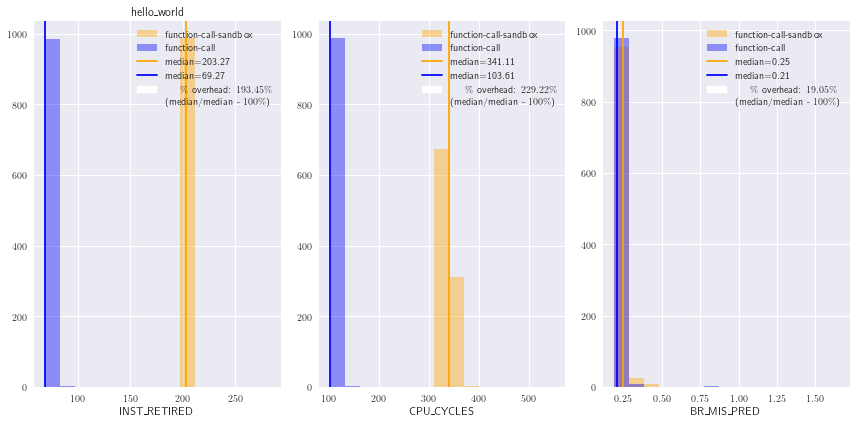

==== lazy-binding ====
Libraries: {'hello_world_with_deps_10'}
Counters: {'BR_MIS_PRED', 'INST_RETIRED', 'CPU_CYCLES'}


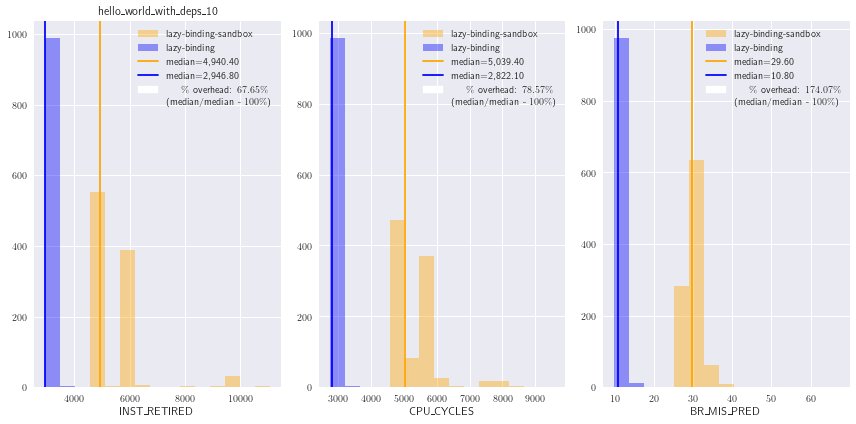

In [80]:
for benchmark in benchmarks:
    print(f"==== {benchmark} ====")
    plot_benchmark_data(
        *load_benchmark_results(benchmark)
    )

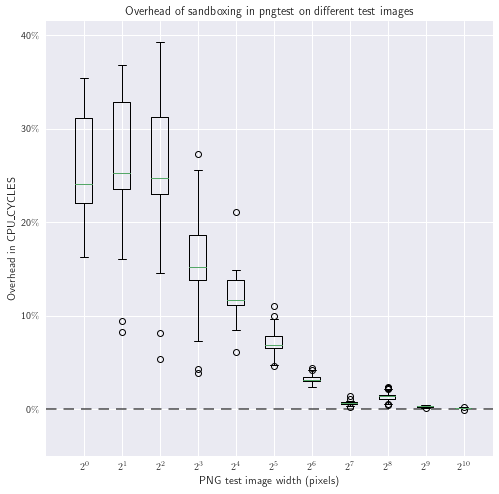

In [109]:
benchmark = "pngtest-parameterised/pngtest-on-testpng32"
counter = "CPU_CYCLES" if 1 else "INST_RETIRED"
mean_baseline, std_baseline, mean_sandbox, std_sandbox, mean_ratio, std_ratio, ratios = [], [], [], [], [], [], []
for i in 2**np.arange(0, 11):
    baseline, sandbox = load_benchmark_results(f"pngtest-parameterised/pngtest-on-testpng{i}", "pngtest")
    mean_baseline.append(np.mean(baseline.loc[:, counter]))
    std_baseline.append(np.std(baseline.loc[:, counter]))
    mean_sandbox.append(np.mean(sandbox.loc[:, counter]))
    std_sandbox.append(np.std(baseline.loc[:, counter]))
    ratio = sandbox / baseline
    ratios.append(ratio.loc[:, counter])
    mean_ratio.append(np.mean(ratio.loc[:, counter]))
    std_ratio.append(np.std(ratio.loc[:, counter]))

mean_baseline = np.array(mean_baseline)
std_baseline = np.array(std_baseline)
mean_sandbox = np.array(mean_sandbox)
std_sandbox = np.array(std_sandbox)
mean_ratio = np.array(mean_ratio)
std_ratio = np.array(std_ratio)
ratios = np.array(ratios)

# TODO: make two axes for the curve and the ratio

fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(2**np.arange(0, 11), mean_baseline, yerr=2*std_baseline, label="baseline")
# ax.errorbar(2**np.arange(0, 11), mean_sandbox,  yerr=2*std_sandbox,  label="sandbox")
# ax.plot(2**np.arange(0, 11), mean_sandbox / mean_baseline, label="ratio")
# ax.plot(2**np.arange(0, 11), mean_ratio - 1, label=f"{counter} $\\pm 2\\sigma$")
# ax.fill_between(2**np.arange(0, 11), mean_ratio - 1 - 2*std_ratio, mean_ratio - 1 + 2*std_ratio, alpha=0.5)
ax.boxplot(ratios.T - 1, positions=2**np.arange(0, 11), widths=0.3*2**np.arange(0, 11))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol="$\%$", is_latex=True))
ax.axhline(y=0, dashes=(6,4), color="black", alpha=0.6)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mtick.LogFormatterSciNotation(base=2))
ax.xaxis.set_major_locator(mtick.LogLocator(base=2, subs=(1.0,)))
ax.xaxis.set_ticks(ticks=2**np.arange(0, 11))
ax.set_xlabel("PNG test image width (pixels)")
ax.set_ylabel(f"Overhead in {counter}")
ax.set_ybound(-0.05, 0.415)
# ax.legend()
# fig.tight_layout()
ax.set_title("Overhead of sandboxing in pngtest on different test images")
plt.show()